<a href="https://colab.research.google.com/github/iyadaithou/Debias/blob/main/debiasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Load the COMPAS dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
data = pd.read_csv(url)

# Select relevant columns
columns_to_use = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid']
data = data[columns_to_use]

# Remove rows with missing data or inconsistent data
data = data[(data.days_b_screening_arrest <= 30) & (data.days_b_screening_arrest >= -30)]
data = data.dropna(subset=['score_text', 'is_recid'])

# Preprocessing
categorical_features = ['c_charge_degree', 'race', 'age_cat', 'sex', 'score_text']
numerical_features = ['age', 'priors_count', 'days_b_screening_arrest', 'decile_score']

# Transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data
X = data.drop('two_year_recid', axis=1)
y = data['two_year_recid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the 'race' column for bias analysis before preprocessing
race_column_train = X_train['race']
race_column_test = X_test['race']

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Neural network model
num_features = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Define a function to calculate the racial bias
def racial_bias_difference(y_true, y_pred, sensitive_data, race_group):
    """ Calculate the difference in positive rates between races """
    group_1 = y_pred[sensitive_data == race_group]
    group_2 = y_pred[sensitive_data != race_group]
    bias_diff = abs(group_1.mean() - group_2.mean())
    return bias_diff

# Calculate racial bias for African-American group
bias_diff = racial_bias_difference(y_test, y_pred, race_column_test, 'African-American')
print(f"Racial Bias Difference (African-American vs Others): {bias_diff}")


In [128]:
def custom_bias_loss(y_true, y_pred, alpha=0.5):
    original_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    if len(y_true.shape) == 1 or y_true.shape[0] != 1:
        bias_penalty = calculate_bias_penalty(y_pred, race_column_train, 'African-American')
    else:
        bias_penalty = 0
    combined_loss = (1 - alpha) * original_loss + alpha * bias_penalty
    return combined_loss

def calculate_bias_penalty(y_pred, sensitive_data, race_group):
    group_1 = tf.boolean_mask(y_pred, sensitive_data == race_group)
    group_2 = tf.boolean_mask(y_pred, sensitive_data != race_group)
    bias_diff = tf.abs(tf.reduce_mean(group_1) - tf.reduce_mean(group_2))
    return tf.square(bias_diff)

# Function to update the last layer
def update_last_layer(model, train_sensitive_data, race_group):
    model.layers[-1].activation = None  # Remove the sigmoid activation
    model.layers[-1].trainable = True  # Make last layer trainable
    new_loss = lambda y_true, y_pred: custom_bias_loss(y_true, y_pred, alpha=0.5)
    model.compile(optimizer='adam', loss=new_loss, metrics=['accuracy'])

# Update the last layer with the custom loss function
update_last_layer(model, race_column_train, 'African-American')

# Evaluate the model using standard binary cross-entropy for accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_loss, new_accuracy = model.evaluate(X_test, y_test)
print(f"New Test Loss: {new_loss:.4f}, New Test Accuracy: {new_accuracy:.4f}")

# Predictions for new bias calculation
new_y_pred = model.predict(X_test)
new_y_pred_binary = (new_y_pred > 0.5).astype(int)

# Calculate the new racial bias for African-American group
new_bias_diff = racial_bias_difference(y_test, new_y_pred_binary, race_column_test, 'African-American')
print(f"New Racial Bias Difference (African-American vs Others): {new_bias_diff}")


39/39 [==============================] - 79s 2ms/step - loss: 3.3554 - accuracy: 0.6745
New Test Loss: 3.3554, New Test Accuracy: 0.6745
39/39 [==============================] - 0s 1ms/step
New Racial Bias Difference (African-American vs Others): 0.20047784649115905


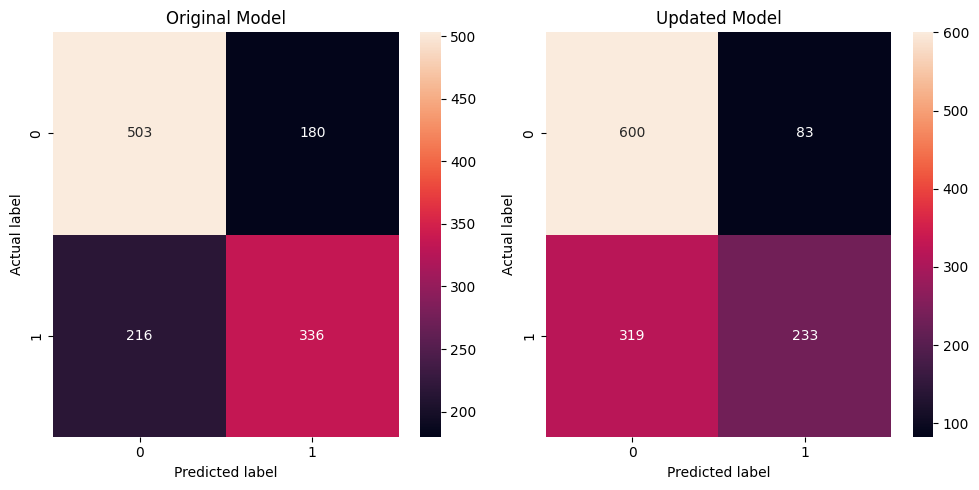

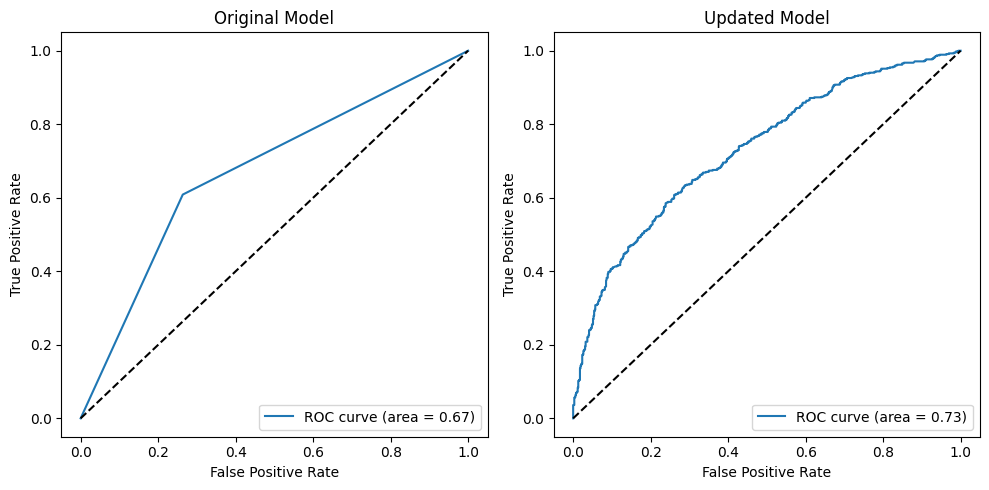

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Confusion matrices for original and updated models
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_confusion_matrix(y_test, y_pred, 'Original Model')

plt.subplot(1, 2, 2)
plot_confusion_matrix(y_test, new_y_pred_binary, 'Updated Model')

plt.tight_layout()
plt.show()

# Function to plot ROC curves
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')

# ROC curves for original and updated models
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_roc_curve(y_test, y_pred, 'Original Model')

plt.subplot(1, 2, 2)
plot_roc_curve(y_test, new_y_pred, 'Updated Model')

plt.tight_layout()
plt.show()


<ipython-input-131-093b48d6ba13>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y_pred[sensitive_data == race], label=race)


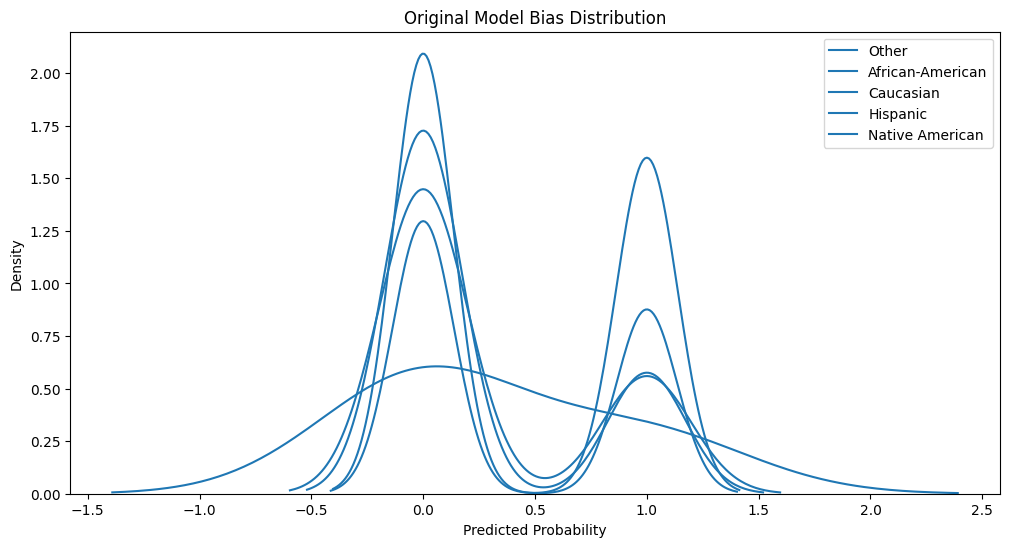

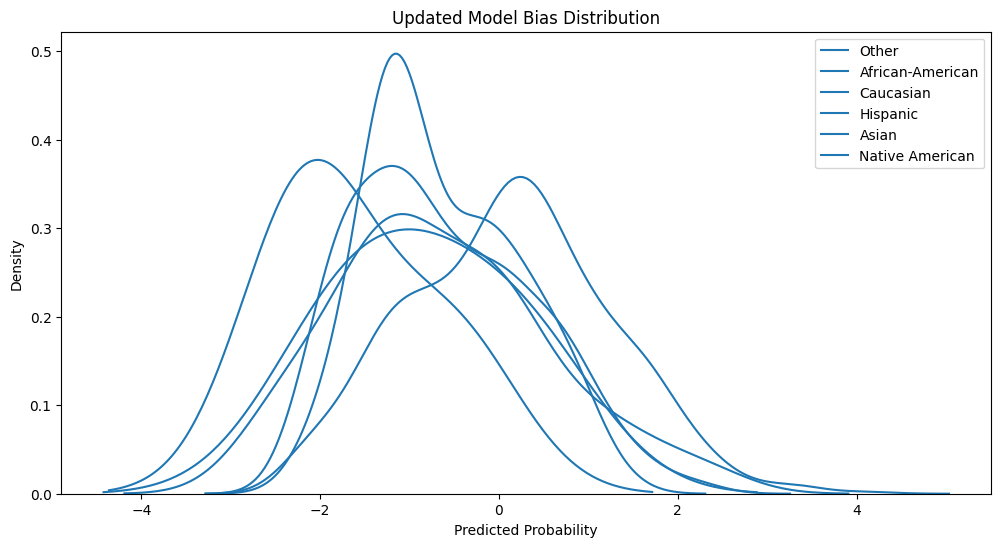

In [131]:
# Function to plot bias distribution
def plot_bias_distribution(y_pred, sensitive_data, race_groups, title):
    plt.figure(figsize=(12, 6))
    for race in race_groups:
        sns.kdeplot(y_pred[sensitive_data == race], label=race)
    plt.title(title)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()

# Plot bias distribution for original and updated models
race_groups = data['race'].unique()
plot_bias_distribution(y_pred, race_column_test, race_groups, 'Original Model Bias Distribution')
plot_bias_distribution(new_y_pred, race_column_test, race_groups, 'Updated Model Bias Distribution')


In [132]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate additional metrics
precision_orig = precision_score(y_test, y_pred)
recall_orig = recall_score(y_test, y_pred)
f1_orig = f1_score(y_test, y_pred)

precision_new = precision_score(y_test, new_y_pred_binary)
recall_new = recall_score(y_test, new_y_pred_binary)
f1_new = f1_score(y_test, new_y_pred_binary)

# Create a DataFrame for comparison
performance_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Original Model': [precision_orig, recall_orig, f1_orig],
    'Updated Model': [precision_new, recall_new, f1_new]
})

print(performance_df)


      Metric  Original Model  Updated Model
0  Precision        0.651163       0.737342
1     Recall        0.608696       0.422101
2   F1 Score        0.629213       0.536866
